In [205]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [10]:
# Читаем данные из файла
with open('checkins.dat') as file:
    lines = file.readlines()

<class 'str'>


In [82]:
# Чистим файл
columns = [ column.strip() for column in lines[0].split('|') ]
clean_lines = []
for line in lines[2:]:
    clean_line = [ element.strip() for element in line.split('|')]
    clean_lines.append(clean_line)
    
# В конце 2 последних списка не нужны
clean_lines = clean_lines[:-2]

# Создаем DataFrame
df = pd.DataFrame(clean_lines, columns = columns)
df.head()

# Сохраняем 
# df.to_csv('banners_clean.csv', index = False)

# Читаем (после чтения появятся NaN values)
# df = pd.read_csv('banners_clean.csv')

# Удаляем строки с NaN values
# df.dropna(inplace = True)

# Сохраняем готовый чистый df
# df.to_csv('banners_clean.csv', index = False)

In [114]:
# Итоговый DataFrame
data = pd.read_csv('banners_clean.csv')

С помощью pandas построим DataFrame и убедимся, что все ```396634``` строки с координатами считаны успешно.

In [116]:
data.shape

(396634, 6)

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом ```MeanShift```, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в ```sklearn user guide```, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте ```MeanShift```, указав ```bandwidth=0.1```, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

**Примечание:**

На ```396634``` строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

In [119]:
# Отберем первые 100к строк
n_rows = 100000
data = data[:n_rows]
data

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
99995,123888,1019078,1105563,33.575000,-117.725556,2011-12-11 05:38:19
99996,124366,771129,329847,37.629349,-122.400087,2011-12-11 04:55:34
99997,125556,804990,254046,29.762884,-95.383061,2011-12-11 06:54:20
99998,127250,526214,34473,32.802955,-96.769923,2011-12-11 10:05:38


In [122]:
# Обучим MeanShift 
from sklearn.cluster import MeanShift

# Отбираем координаты
x = data[['latitude', 'longitude']].values

# Кластеризируем
clustering = MeanShift(bandwidth=0.1).fit(x)

In [167]:
# Посмотрим на центры кластеров 
clustering.cluster_centers_.shape
print(f'All Found Clusters: {clustering.cluster_centers_.shape[0]}')

# Принадлежности точке кластерам
cluster_point = clustering.labels_
n_clusters = np.unique(cluster_point).shape[0]
print(f'Number of Unique Clusters: {n_clusters}')

All Found Clusters: 3231
Number of Unique Clusters: 3231


Было найдено ```3231``` кластеров или потенциальных мест скопления туристов

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт ```mapcustomizer.com``` имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате: long lat

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо **определить, какие из кластеров содержат, скажем, больше 15 элементов.** Центры этих кластеров и являются оптимальными для размещения.

In [215]:
# Посмотрим сколько точке принадлежит каждому из кластерова
values = pd.Series(cluster_point)

# Найдем индексы кластеров в которых больше 15 элементов 
selected_clusters_indexes = values.value_counts()[values.value_counts() > 15] 

Number of clusters with more than 15 observations: 592


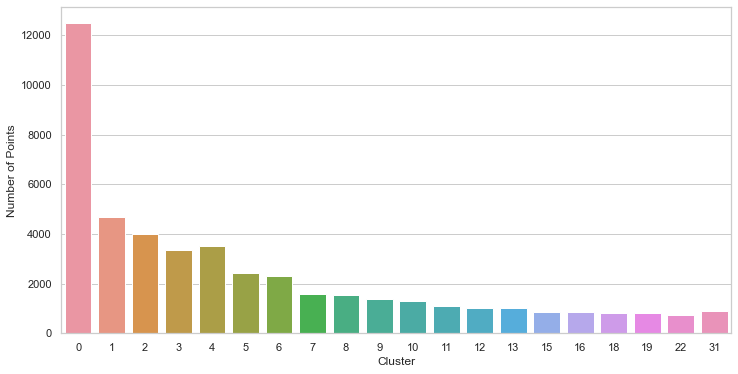

In [219]:
# Нарисуем гистограмму по кластерам
plt.figure(figsize = (12,6))
sns.barplot(x = selected_clusters_indexes.index[:20], y = selected_clusters_indexes.values[:20])
plt.ylabel('Number of Points')
plt.xlabel('Cluster');
print(f'Number of clusters with more than 15 observations: {len(selected_clusters_indexes)}')

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на ```Google Maps``` по запросу ```Carnival Cruise Line``` адреса всех офисов:
- ```Los Angeles:``` 33.751277, -118.188740
- ```Miami:``` 25.867736, -80.324116
- ```London:``` 51.503016, -0.075479
- ```Amsterdam:``` 52.378894, 4.885084
- ```Beijing:``` 39.366487, 117.036146
- ```Sydney:``` -33.868457, 151.205134

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

In [295]:
# Отбираем нужные центры кластеров
selected_clusters_centers = clustering.cluster_centers_[selected_clusters_indexes.index]

# Создаем массив координат всех офисов
offices = np.array([[33.751277, -118.188740],[25.867736, -80.324116], [51.503016, -0.075479], [52.378894, 4.885084],
                   [39.366487, 117.036146], [-33.868457, 151.205134]])

# Функция для расчета расстояния
def calculate_euclidean_distance(pnt_1, pnt_2):
    return ((pnt_1[0] - pnt_2[0])**2 + (pnt_1[1] - pnt_2[1])**2)**0.5

# Считаем расстояния между всеми офисами и всеми кластерами
all_distances = {}
# Делаем enumerate чтобы запомнить индекс офиса и индекс кластера
for idx, office in enumerate(offices):
    for cluster_idx, cluster_center in enumerate(selected_clusters_centers):
        # Cладываем все расстояния
        all_distances[f'{idx}_{cluster_idx}'] = calculate_euclidean_distance(office, cluster_center)
        
# Отбираем только значения расстояний и сортируем их
sorted_distances = sorted(list(all_distances.values()))

# Отбираем 20 самых минимальных расстояний
top_20_min_dist = sorted_distances[:20]

# Находим самое минимальное расстояние (т.е.самый близкий кластер к одному из 6 офисов)
closest_cluster_dist = top_20_min_dist[0]

# Теперь найдем сам офис и ближайший до него кластер, используя closest_cluster_dist
# Для этого найдем индекс найденного минимального расстояния в списке из словоря расстояний all_distances
min_dist_indx = list(all_distances.values()).index(closest_cluster_dist)

# Найдем нужный нам кластер и офис в словаре, сипользуя найденный индекс
res = list(all_distances.items())[min_dist_indx]
found_office = res[0].split('_')[0]
found_cluster = res[0].split('_')[1]
print(f'Самое минимальное расстояние между офисом {found_office} и кластером {found_cluster}')
print(f'Расстояние: {res[1]}')
print()
# Координаты
print(f'Координаты ближайшего офиса: {offices[5]}')
print(f'Координаты ближайшего кластера: {selected_clusters_centers[397]}')

Самое минимальное расстояние между офисом 5 и кластером 397
Расстояние: 0.007834758163107856

Координаты ближайшего офиса: [-33.868457 151.205134]
Координаты ближайшего кластера: [-33.86063043 151.20477593]
